在這一章節中，主要要介紹分類問題。我們主要會使用 MNIST 這個資料集，裡面包含了 70,000 張手寫數字，從 0 ~ 9。

首先，先引入必要的套件並針對 matplotlib 做基礎設定，讓我們之後在繪圖時能有一致的格式。

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

scikit-learn 在 0.20 後，提供了新的 API `fetch_openml` 來下載公開資料集。

In [4]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, data_home='~/scikit_learn_data')
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    print('start sorting...')
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    print('error!')
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]
X, y = mnist["data"], mnist["target"]
X, y

start sorting...


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

我們把每個手寫圖片的標準答案透過 pandas 的 series 來看一下分佈狀況如何，可以看到每個數字的圖片數目雖然不同，但相差不遠。

In [5]:
pd.Series(y).value_counts().sort_index(axis=0)

0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
dtype: int64

讓我們取出其中一個數字，透過 matplotlib 畫出來看看。注意，在這裡要先把一維的資料 `reshape` 成 28*28

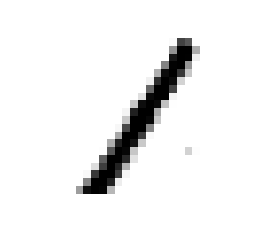

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[10000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

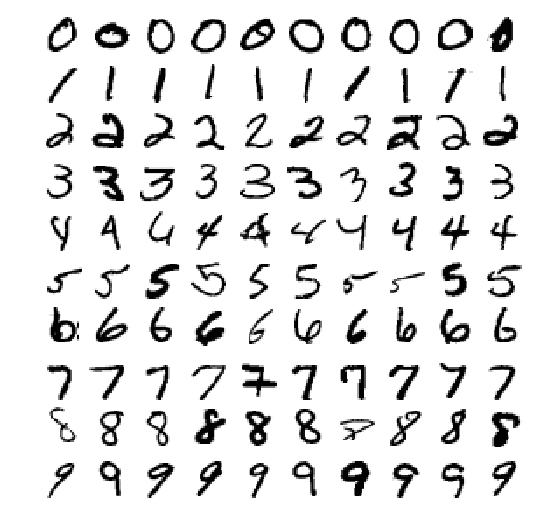

In [8]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

切 train/test 資料。前 60,000 筆是 training data，後 10,000 筆是 testing data

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print('Training data size: ', len(X_train))
print('Testing data size: ', len(X_test))

Training data size:  60000
Testing data size:  10000


打亂 training data 的順序

In [10]:
import numpy as np

shuffle_index = np.random.permutation(60000)
print(shuffle_index)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

[12628 37730 39991 ...   860 15795 56422]


In [11]:
# train data label distribution
pd.Series(y_train).value_counts().sort_index(axis=0)

0    5923
1    6742
2    5958
3    6131
4    5842
5    5421
6    5918
7    6265
8    5851
9    5949
dtype: int64

In [12]:
# test data distribution
pd.Series(y_test).value_counts().sort_index(axis=0)

0     980
1    1135
2    1032
3    1010
4     982
5     892
6     958
7    1028
8     974
9    1009
dtype: int64

## Binary Classification

這裡我們來練習 Binary Classification。讓我們訓練一個分類器，用來辨識 mnist 的圖片是不是 5。先把 training 和 testing 的 y label 都改成 true/false。true 代表是 5，false 代表非 5

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [15]:
some_digit = X[0]

# predict some_digit by SGDClassifier trained in the previous step
sgd_result = sgd_clf.predict([some_digit])
sgd_result

array([False])

sklearn 提供了 cross validation 的函式 cross_val_score，這裡我們用 cv=3，也就是 3-fold cross-validation。

In [16]:
from sklearn.model_selection import cross_val_score
sgd_cvs = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
sgd_cvs

array([0.9502 , 0.96565, 0.96495])

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


儘管我們上面訓練的分類器看起來 accuracy 好像已經很高了，但是事實上這樣真的就沒問題嗎？我們建立一個分類器，這個分類器永遠不會猜 5。

In [18]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

可以看到這個分類器的 accuracy 也是高達 90% 左右。所以並不是 SGDClassifier 的能力強，而是我們的資料的特性使然，MNIST 本來有 0~9 十類手寫數字，我們只判斷資料是不是 5，那麼標記為 5 的資料量和 “非5” 的比例就是1:9，所以即便是全部猜成是 “非5” 也可以得到90%的準確率。從這個小例子我們可以看出當樣本極其不均衡時，僅僅考慮 accuracy 是無法衡量一個分類器的好壞的。

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

## 使用混淆矩陣 (Confusion Metrics) 來作為模型的衡量維度

[cross_val_predict](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) 會利用 cross-validation 的機制，把每個 fold 的預測結果回傳。

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

在 sklearn 使用 confusion metrics 時，只需要把標準答案 (y_train_5) 和模型預測的答案 (y_train_pred) 丟到 confusion_metrix 函式中即可。

In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

讓我們來看看以下四種分類器的衡量指標。分別是：
- accuracy
- precision
- recall
- f1-score 

Accuracy 看的是總樣本數中 (TP + TN + FP + FN)，實際預測正確的樣本數 (TP + TN)。
Precision 看的是每次模型預測的所有結果 (TP + FP)，有多少是正確的 (TP)。
Recall 看的是在所有應該被模型預測為正確的集合中 (TP + FN)，有多少是正確被預測出來的 (TP)。
F1-Score 則是 precision 和 recall 的調和平均數 (Harmonic mean)。

- Accuracy = (TP + TN) / (TP + TN + FP + FN)
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)
- F1 = 2 / (1/Precision) + (1/Recall)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

acc = accuracy_score(y_train_5, y_train_pred)
pre = precision_score(y_train_5, y_train_pred)
rec = recall_score(y_train_5, y_train_pred)
f1 = f1_score(y_train_5, y_train_pred)

print('acc: %.3f, precision: %.3f, recall: %.3f, f1-score: %.3f' % (acc, pre, rec, f1))

acc: 0.960, precision: 0.769, recall: 0.801, f1-score: 0.785


## 觀察 precison/recall 與 threshold curve

為了得到 precision/recall 對 threshold 的關係，我們可以再次利用 `cross_val_predict` 函式，只是這次我們指定 `method="decision_function"` 來得到決策的分數，而不是預測值。

關於 method 可以傳入的值，可以參考 cross_val_predict 的原始碼：[https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L756](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/model_selection/_validation.py#L756)，可以有 `'decision_function', 'predict_proba', 'predict_log_proba'` 等。這之間當然有差別，但我們在這裡並不贅述。



In [23]:
# cross_val_predict return predict results
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")
y_scores

array([ -434076.49813641, -1825667.15281624,  -767086.76186905, ...,
        -867191.25267994,  -565357.11420164,  -366599.16018198])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print(precisions, recalls, thresholds)

[0.09080706 0.09079183 0.09079335 ... 1.         1.         1.        ] [1.00000000e+00 9.99815532e-01 9.99815532e-01 ... 3.68935621e-04
 1.84467810e-04 0.00000000e+00] [-1613405.71147769 -1612415.64410228 -1611701.37464018 ...
   954170.04762499   987947.69103863  1002862.09359785]


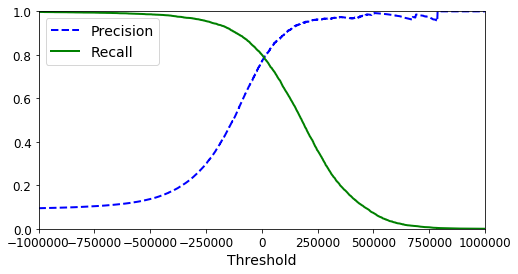

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-1000000, 1000000])
plt.show()

## 觀察 precision-recall curve

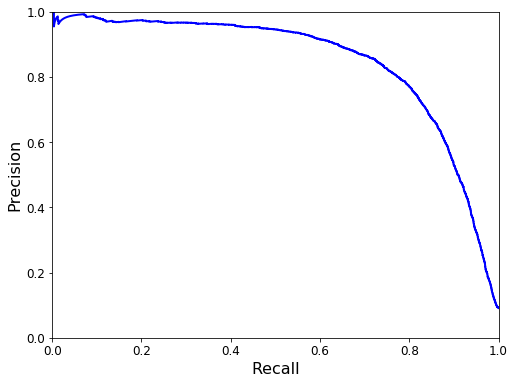

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## ROC Curve

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99446674, 0.99446674,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 3.87382402e-03, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([ 1002863.09359785,  1002862.09359785,   788024.40783823, ...,
        -1612415.64410228, -1613405.71147769, -2922518.84137436]))

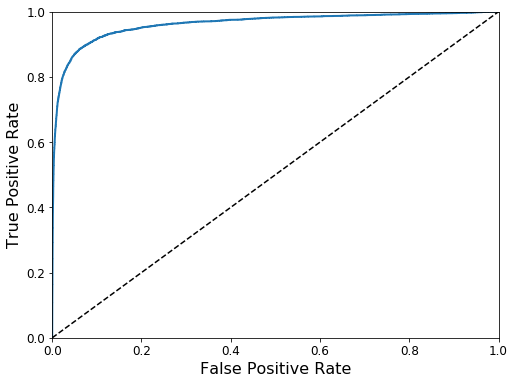

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

## Multiclass classification

現實世界中，我們比較常遇到的多分類的問題。有一些分類器本質上就是一個 binary classifier，比如說 SVM，它本質上要找到一個超平面來將兩群資料在不同的 space 上分開，但某些分類器則在本質上就是多分類器，比如說 tree-based 的 random forest。

為了要讓 binary classifier 可以應用在多分類的問題上，就要來談談 "one-vs-one" 和 "one-vs-all" 這兩個概念。這兩個概念背後的原理，其實就是把一個多分類的問題，轉換成數個 binary classification 的問題。

### one-vs-all

如果我們想辨識 mnist 的 10 個手寫數字，但我們的分類演算法天生就是只能辨識兩類時，第一個做法是 one-vs-all。概念是這樣的：如果我們有 3 個類別，就訓練 3 個 binary classifier：c1, c2, c3：

- c1 分類器用來區分類別 1 和其他：類別 1 當成 positive samples，其他都是 negative samples
- c2 分類器用來區分類別 2 和其他：類別 2 當成 positive samples，其他都是 negative samples
- c3 分類器用來區分類別 3 和其他：類別 3 當成 positive samples，其他都是 negative samples

而在 inference 時，我們拿到一個沒看過的 sample，分別用 c1、c2、c3 去做 predict，得到最高 confidence score 的分類器就是該 sample 的類別。

- 優點
    - 有多少類別就訓練多少個二元分類器，直覺且容易理解
- 缺點
    - 容易遇到 data imbalanced 的問題，想像一下，你在每次訓練時，只挑選一個類別當成 positive，其餘都視為 negative，當類別數量多的時候，每一次的訓練 negative 的數量會遠大於 positive

### one-vs-one
第二種做法是 one-vs-one。概念是：針對兩兩類別訓練一個 binary classifier，如果我們有 3 個類別，就訓練 c12、c23、c13 三個 binary classifier：
- c12 分類器用來區別類別 1 和類別 2：類別 1 當成 positive samples，類別 2 是 negative samples
- c23 分類器用來區別類別 2 和類別 3：類別 2 當成 positive samlpes，類別 3 是 negative samples
- c13 分類器用來區別類別 1 和類別 3：類別 1 當成 positive samlpes，類別 3 是 negative samples

具體來說，如果你有 N 個類別，就要訓練 N*(N-1)/2 個分類器。所以有四個類別，就要訓練六個分類器，有五個類別，就要訓練十個分類器...依此類推。在 inference 時，一個新的 sample 就要經過所有的分類器進行預測，取預測的 score 最高的類別作為最後的答案。

- 優點
    - 兩兩訓練的分類器會比 one-vs-all 穩定，因為看的樣本數目比較平均
- 缺點
    - 在 inference 的時候會比 one-vs-all 來得慢，因為分類器數量較多

在 sklearn 中，透過 OneVsOneClassifier 就可以很容易的實現 one-vs-one 的訓練方式

In [29]:
from sklearn.multiclass import OneVsOneClassifier
base_classifier = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
ovo_clf = OneVsOneClassifier(base_classifier)
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=int8)

透過 OneVsOneClassifier 的 estimators_ attribute，可以看到 one-vs-one 的分類方法使用了 10*(10-1)/2 = 45 個分類器來進行最後的預測：

In [30]:
len(ovo_clf.estimators_)

45

而 one-vs-all 的分類器在 sklearn 中需要使用 OneVsRestClassifier：

In [31]:
from sklearn.multiclass import OneVsRestClassifier
ova_clf = OneVsRestClassifier(base_classifier)
ova_clf.fit(X_train, y_train)
ova_clf.predict([some_digit])

array([0], dtype=int8)

可以看到 one-vs-all 的分類器使用了 10 個分類器來進行預測：

In [32]:
len(ova_clf.estimators_)

10

## 觀察分類器的分類結果

透過 cross_val_score 可以看到我們在 cross validation 下的 accuracy 大概是 85% 左右

In [33]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.90796841, 0.91494575, 0.91383708])

讓我們使用 confusion matrix 來看看分類器的分類結果，一樣先使用 cross_val_predict 來產生 model predict 的結果，然後透過 confusion_matrix 來觀看結果

In [34]:
y_train_predicted = cross_val_predict(ovo_clf, X_train, y_train, cv=3)
conf_matrix = confusion_matrix(y_train, y_train_predicted)
conf_matrix

array([[5741,    1,   26,   11,    8,   51,   34,    6,   35,   10],
       [   2, 6455,   61,   36,    4,   16,    4,   12,  140,   12],
       [  41,   44, 5439,   90,   51,   31,   65,   58,  128,   11],
       [  20,   17,  117, 5381,    1,  300,   14,   49,  184,   48],
       [  16,   27,   43,    6, 5071,   23,   46,   38,   70,  502],
       [  65,   13,   42,  167,   25, 4670,   83,    9,  288,   59],
       [  45,    9,   78,    3,   29,   58, 5653,    2,   41,    0],
       [  13,   21,   67,   53,   41,    7,    2, 5635,   32,  394],
       [  22,   58,  111,  128,    7,  180,   33,   16, 5230,   66],
       [  18,   33,   24,   62,   64,   27,    2,  179,   80, 5460]])

我們可以用視覺化圖表來呈現 confusion matrix 的結果。我們可以用 confusion matrix 的圖形化來顯示目前分類器的效果，越深的地方代表預測的落點，這個分類器分類的效果看起來不錯，主要的預測都在對角線上，代表預測正確。

而可以看到 true label 是 4，而 predict label 是 9 的格子相對其他地方的顏色稍微深一點，就代表模型在預測真的為 4 的數字上表現比較差一點，有比較多的機率會猜成 9。

這也給我們進一步調整模型的方向。

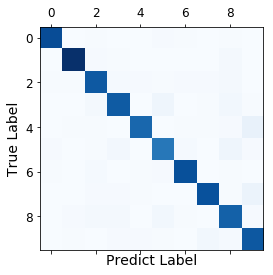

In [35]:
plt.matshow(conf_matrix, 
            cmap=plt.cm.Blues)

plt.xlabel('Predict Label')
plt.ylabel('True Label')
plt.show()

進一步來看，每個類別因為數量的不同，所以單看絕對數字可能會有所偏頗，所以我們應該來看看 normalize 過後的結果。讓我們把 confusion matrix 的每一個值去除上每個類別的數量，看看正歸化之後的模型表現。

我們把每一行相加，`row_sums` 代表的是每個類別的總和。接著把 confusion matrix 去除以 `row_sums`，就可以得到 normalize 過後的 matrix。

In [36]:
row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_mx = conf_matrix / row_sums
norm_conf_mx

array([[9.69272328e-01, 1.68833361e-04, 4.38966740e-03, 1.85716698e-03,
        1.35066689e-03, 8.61050144e-03, 5.74033429e-03, 1.01300017e-03,
        5.90916765e-03, 1.68833361e-03],
       [2.96647879e-04, 9.57431029e-01, 9.04776031e-03, 5.33966182e-03,
        5.93295758e-04, 2.37318303e-03, 5.93295758e-04, 1.77988727e-03,
        2.07653515e-02, 1.77988727e-03],
       [6.88150386e-03, 7.38502853e-03, 9.12890232e-01, 1.51057402e-02,
        8.55991944e-03, 5.20308828e-03, 1.09097012e-02, 9.73481034e-03,
        2.14837194e-02, 1.84625713e-03],
       [3.26211059e-03, 2.77279400e-03, 1.90833469e-02, 8.77670853e-01,
        1.63105529e-04, 4.89316588e-02, 2.28347741e-03, 7.99217093e-03,
        3.00114174e-02, 7.82906541e-03],
       [2.73878809e-03, 4.62170490e-03, 7.36049298e-03, 1.02704553e-03,
        8.68024649e-01, 3.93700787e-03, 7.87401575e-03, 6.50462170e-03,
        1.19821979e-02, 8.59294762e-02],
       [1.19904077e-02, 2.39808153e-03, 7.74764804e-03, 3.08061243e-02,
   

在這裡有一個小技巧，因為我們想要觀察的是模型表現比較不好的是哪些類別，所以完全猜對的部分不是我們所關心的，我們透過 `fill_diagonal` 把 matrix 的對角線都設為 0，這樣我們在繪圖的時候，對角線就會呈現一致的顏色，讓我們方便觀察其他猜錯的部分的狀況為何。

可以看到 `norm_conf_mx` 的 output 就是我們把對角線都設定為 0 後的結果。

In [37]:
np.fill_diagonal(norm_conf_mx, 0)
norm_conf_mx

array([[0.        , 0.00016883, 0.00438967, 0.00185717, 0.00135067,
        0.0086105 , 0.00574033, 0.001013  , 0.00590917, 0.00168833],
       [0.00029665, 0.        , 0.00904776, 0.00533966, 0.0005933 ,
        0.00237318, 0.0005933 , 0.00177989, 0.02076535, 0.00177989],
       [0.0068815 , 0.00738503, 0.        , 0.01510574, 0.00855992,
        0.00520309, 0.0109097 , 0.00973481, 0.02148372, 0.00184626],
       [0.00326211, 0.00277279, 0.01908335, 0.        , 0.00016311,
        0.04893166, 0.00228348, 0.00799217, 0.03001142, 0.00782907],
       [0.00273879, 0.0046217 , 0.00736049, 0.00102705, 0.        ,
        0.00393701, 0.00787402, 0.00650462, 0.0119822 , 0.08592948],
       [0.01199041, 0.00239808, 0.00774765, 0.03080612, 0.0046117 ,
        0.        , 0.01531083, 0.00166021, 0.05312673, 0.0108836 ],
       [0.00760392, 0.00152078, 0.01318013, 0.00050693, 0.0049003 ,
        0.00980061, 0.        , 0.00033795, 0.00692802, 0.        ],
       [0.00207502, 0.00335196, 0.0106943

從圖上可以看到，顏色越亮的區塊，代表模型表現比較不好的地方，這就讓我們很清楚地知道哪一塊是我們要進一步去改善。

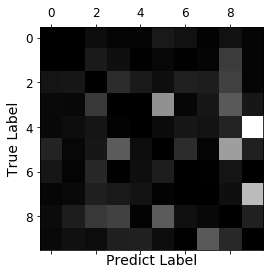

In [40]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xlabel('Predict Label')
plt.ylabel('True Label')
plt.show()